# Atividade Computacional Redes Neurais 2025.1
---
Discente: João Victor Moreira Cardoso

---

## Problema

Seja a função 

$$
f(\mathbf{x}) = \sum_{n=1}^{D}(x_n)^{2n} - exp\{-\sum_{n=1}^{D}\epsilon_n(x_n)^{2n}\}
$$

onde:
- $\mathbf{x} = [x_1\,\,x_2\,\,\dots\,\,x_n\,\,\dots\,\,x_D]^{T},\,\,\, x \in [-30,30]\,$;
- Cada $0 \leqslant \epsilon_n \leqslant 1$ é sorteado de uma distribuição uniforme $\implies$ podemos criar um vetor $\mathbf{\epsilon} = [\epsilon_1\,\,\epsilon_2\,\,\dots\,\,\epsilon_D]$ de mesma dimensão $D$;
---
Para $D=3$:

$$
f(\mathbf{x}) = (x_1)^{2}+(x_2)^{4}+(x_3)^{6} - exp\{-[\epsilon_1(x_1)^{2}+\epsilon_2(x_2)^{2}+\epsilon_3(x_3)^{6}]\}
$$

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

from math import sqrt
from tqdm import tqdm

import pandas as pd
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 200

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate,train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error, r2_score
import random
from random import seed,randrange
import requests
import io

import matplotlib.patches as mpatches
import seaborn as sns
import pdflatex

from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.linalg import norm

import warnings
warnings.filterwarnings("ignore")

## Dataset

### (a) Sorteio dos valores de $\epsilon_n$

In [2]:
np.random.seed(42)  # Para reprodutibilidade
D = 3 # Dimensão do vetor epsilon
n_points = 2000
epsilon = np.array(np.random.uniform(0,1,D))
print(f"Valores de epsilon_n sorteados: {epsilon}")


Valores de epsilon_n sorteados: [0.37454012 0.95071431 0.73199394]


### (b)(i) Geração dos pontos da função $(\vec{x}_n,f(\vec{x}_n))$

In [25]:
def f(x, epsilon):
    """Calcula a função f(x) conforme definida"""
    sum_x = np.sum([x_n**(2*(n+1)) for n, x_n in enumerate(x)]) # Termo da Soma
    exp_term = np.exp(-np.sum([epsilon[n] *(x_n**(2*(n+1))) for n, x_n in enumerate(x)])) # Termo Exponencial
    return sum_x - exp_term

# Gerar 2000 pontos aleatórios no intervalo [-30, 30]
X = np.random.uniform(-30, 30, (n_points, D))
y = np.array([f(x, epsilon) for x in X])


### (b)(ii) Informar os pontos da função $(\vec{x}_n,f(\vec{x}_n))$

In [26]:
print(f'Vetor X:\n', X, '\n')

Vetor X:
 [[ 13.00348696  22.57836178 -13.66687195]
 [ -9.47539224  25.84436378   4.71070754]
 [-19.26229097   9.82170833  29.44572933]
 ...
 [-20.72989131  24.7982829   -4.29161411]
 [ -7.32804051 -16.12081195   8.14538006]
 [ 11.1316809   -1.94574226 -26.65758626]] 



In [27]:
print(f'Vetor y:\n', y, '\n')

Vetor y:
 [6.77655250e+06 4.57149190e+05 6.51839001e+08 ... 3.84846932e+05
 3.59648951e+05 3.58860044e+08] 



### (b)(iii) Visualização dos pontos da função $(\vec{x}_n,f(\vec{x}_n))$

#### Bidimensional


(b) Distribuição dos pontos:
Treinamento: 1500 pontos
Validação: 250 pontos
Teste: 250 pontos


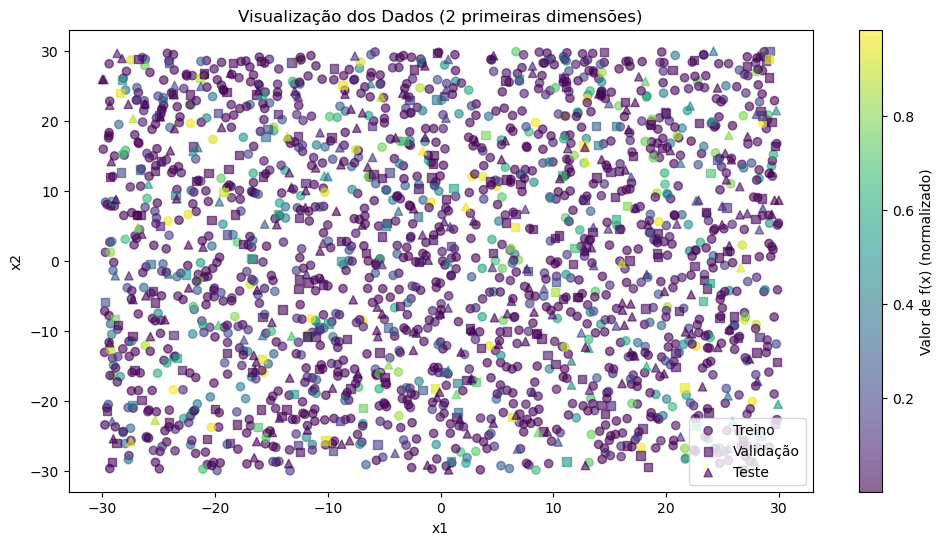

In [28]:
# Dividir em treino (1500), validação (250) e teste (250)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=500, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\n(b) Distribuição dos pontos:")
print(f"Treinamento: {X_train.shape[0]} pontos")
print(f"Validação: {X_val.shape[0]} pontos")
print(f"Teste: {X_test.shape[0]} pontos")

# Normalizar os valores de y para o intervalo [0,1]
norm = Normalize(vmin=min(y_train.min(), y_val.min(), y_test.min()), 
                vmax=max(y_train.max(), y_val.max(), y_test.max()))

plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=norm(y_train), cmap='viridis', alpha=0.6, label='Treino')
plt.scatter(X_val[:, 0], X_val[:, 1], c=norm(y_val), cmap='viridis', marker='s', alpha=0.6, label='Validação')
plt.scatter(X_test[:, 0], X_test[:, 1], c=norm(y_test), cmap='viridis', marker='^', alpha=0.6, label='Teste')

# Adicionar barra de cores
cbar = plt.colorbar()
cbar.set_label('Valor de f(x) (normalizado)')

plt.title("Visualização dos Dados (2 primeiras dimensões)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

#### Tridimensional

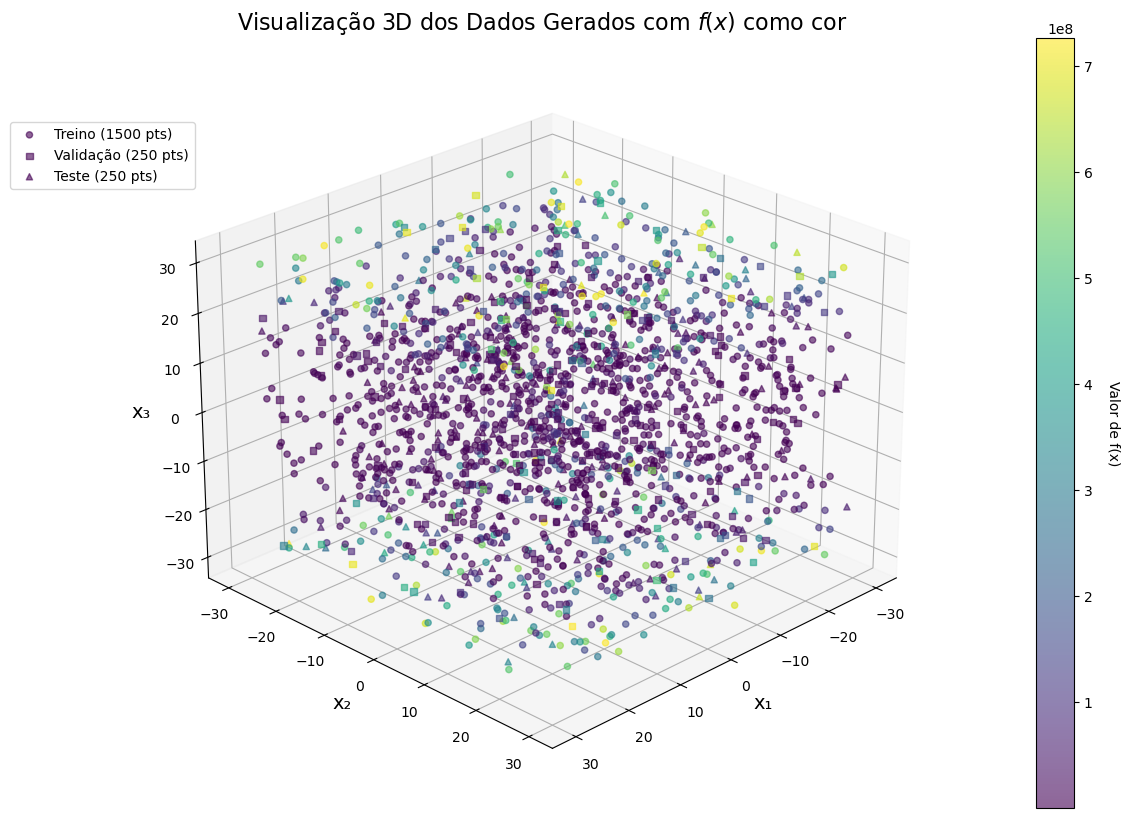

In [29]:
# Configuração do gráfico 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot dos pontos de treinamento
sc_train = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], 
                      c=y_train, cmap='viridis', alpha=0.6, 
                      label='Treino (1500 pts)', marker='o')

# Plot dos pontos de validação
sc_val = ax.scatter(X_val[:, 0], X_val[:, 1], X_val[:, 2], 
                    c=y_val, cmap='viridis', alpha=0.6, 
                    label='Validação (250 pts)', marker='s')

# Plot dos pontos de teste
sc_test = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], 
                     c=y_test, cmap='viridis', alpha=0.6, 
                     label='Teste (250 pts)', marker='^')

# Configurações do gráfico
ax.set_title(f'Visualização 3D dos Dados Gerados com $f(x)$ como cor', fontsize=16)
ax.set_xlabel('x₁', fontsize=14)
ax.set_ylabel('x₂', fontsize=14)
ax.set_zlabel('x₃', fontsize=14)

# Adicionando barra de cores
cbar = fig.colorbar(sc_train, ax=ax, pad=0.1)
cbar.set_label('Valor de f(x)', rotation=270, labelpad=20)

# Ajustando a legenda
ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 0.9))

# Ajustando o ângulo de visualização
ax.view_init(elev=25, azim=45)
plt.show()

## Treinamento

Como estamos tratando de um problema de regressão, uma vez que não temos as classes dos pontos bem definidas, temos que ajustar as métricas e os modelos para atuarem como regressores.

- Modelos:
    - MLP-BP de Três Camadas: usaremos o [MLPRegressor da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
    - RBF de Três Camadas: construí uma rotina própria de RBF com k-means
    - SVM com Kernel: usaremos o [SVR da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

- Métricas:
    - Mean Squared Error: usaremos o [MSE da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) para analisar o quanto o modelo está errando
    - $R^2$ Score: usaremos o [$R^2$ da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) para analisar o desempenho global dos modelos

### Função para avaliação de modelos

In [8]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Avalia um modelo e retorna métricas"""
    model.fit(X_train, y_train)
    
    # Previsões
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    r2_test = r2_score(y_test, y_pred_test)
    
    return {
        'mse': {'train': mse_train, 'val': mse_val, 'test': mse_test},
        'r2': {'train': r2_train, 'val': r2_val, 'test': r2_test}
    }, y_pred_train,y_pred_val,y_pred_test


### Normalização dos Dados

Fazemos isso para que os valores numéricos não estourem. Para tal, usamos o [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) que atua como um z-score:
$$
z=\frac{x - \mu}{\sigma}
$$

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).ravel()

### (c) MLP-BP de três camadas

Implementei um MLP de 3 camadas em que:
- Camada escondida contém apenas 20 neurônios;
- Função de ativação para o cálculo do Net é a 'ReLU' $\equiv$ Rectified Linear Unit Function
- Regra de Atualização dos Pesos: 'adam'
- Número Máximo de Iterações: 1000

In [ ]:
print("\n(c) Treinando MLP-BP de três camadas...")
mlp = MLPRegressor(hidden_layer_sizes=(20,), activation='relu',
                solver='adam', max_iter=1000, random_state=42)

mlp_metrics, y_mlp_pred_train,y_mlp_pred_val,y_mlp_pred_test = evaluate_model(mlp, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled)
print("MSE - Treino:", mlp_metrics['mse']['train'], "| Validação:", mlp_metrics['mse']['val'], "| Teste:", mlp_metrics['mse']['test'])
print("R² - Treino:", mlp_metrics['r2']['train'], "| Validação:", mlp_metrics['r2']['val'], "| Teste:", mlp_metrics['r2']['test'])
#Imprimindo os Pesos e os Biases Finais Utilizados
print("\nPesos Finais Utilizados:")
print(mlp.coefs_)
print("\nBiases Finais Utilizados:")
print(mlp.intercepts_)


(c) Treinando MLP-BP de três camadas...
MSE - Treino: 0.022905393168026783 | Validação: 0.023485987908120867 | Teste: 0.03186481619301654
R² - Treino: 0.9770946068319732 | Validação: 0.9787385769190651 | Teste: 0.9712385445357153

Pesos Finais Utilizados:
[array([[ 5.56212016e-02,  6.12500640e-01,  3.28082084e-01,
         1.89035836e-01, -4.89446120e-01, -2.83459947e-01,
        -3.62582531e-02, -1.97322758e-02, -3.97863002e-61,
        -2.78736902e-01, -5.16187355e-01,  5.76768359e-02,
        -3.83919910e-02, -4.51444535e-01, -2.78850506e-01,
        -7.96659945e-02, -3.88482578e-01,  4.98694266e-03,
        -2.51186648e-01, -1.49928149e-01],
       [ 1.40628183e-02, -1.83040916e-01, -3.70123289e-01,
        -2.36351715e-01, -2.26176044e-01,  2.84212426e-01,
        -7.25825338e-03,  3.48854657e-02, -5.96131116e-63,
        -4.88616874e-01,  1.17057988e-01,  1.65943206e-02,
         1.83818016e-02, -1.86666254e-01,  3.20887315e-01,
        -7.10286558e-02,  1.81854737e-01, -6.69581

### (d) RBF de três camadas

Construí uma RBF de forma que:
- Usa K-means para encontrar centros representativos nos dados em que $K=50$ centros;
- Calcula a ativação de cada neurônio RBF usando função Gaussiana: $φ(||\vec{x}_n - c_i||) = exp(-||\vec{x}_n - c_i||² / (2σ²))$, o que faz com que cada neurônio responda mais intensamente a pontos próximos ao seu centro;
- Camada de saída com combinação linear das ativações RBF;
- Usa pseudoinversa para resolver o sistema linear (mais estável que inversão direta);

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, RegressorMixin

print("\n(d) Treinando RBF de três camadas...")


class RBFNetwork(BaseEstimator, RegressorMixin):
    def __init__(self, n_centers=50, sigma=1.0):
        self.n_centers = n_centers # Quantidae de Neurônios na Camada Oculta
        self.sigma = sigma # Parâmetro de largura das funções RBF
        
    def _rbf_function(self, X, centers):
        # Usando cdist para calcular as distâncias euclidianas
        return np.exp(-cdist(X, centers, 'sqeuclidean') / (2 * self.sigma**2))
    
    def fit(self, X, y):
        # Camada 1: Encontrar centros com K-means
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers_ = kmeans.cluster_centers_
        
        # Camada 2: Calcular saídas RBF
        rbf_features = self._rbf_function(X, self.centers_)
        
        # Camada 3: Regressão linear (usando pseudoinversa para estabilidade numérica)
        self.weights_ = np.linalg.pinv(rbf_features) @ y
        return self
        
    def predict(self, X):
        rbf_features = self._rbf_function(X, self.centers_)
        return rbf_features @ self.weights_
    
rbf = RBFNetwork()

rbf_metrics, y_rbf_pred_train,y_rbf_pred_val,y_rbf_pred_test = evaluate_model(rbf, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled)
print("MSE - Treino:", rbf_metrics['mse']['train'], "| Validação:", rbf_metrics['mse']['val'], "| Teste:", rbf_metrics['mse']['test'])
print("R² - Treino:", rbf_metrics['r2']['train'], "| Validação:", rbf_metrics['r2']['val'], "| Teste:", rbf_metrics['r2']['test'])

# Imprimindo os centros finais
print("\nCentros finais utilizados:")
print(rbf.centers_)


(d) Treinando RBF de três camadas...
MSE - Treino: 0.13515109264031638 | Validação: 0.13925535290069535 | Teste: 0.1575739871134859
R² - Treino: 0.8648489073596837 | Validação: 0.8739347484172543 | Teste: 0.8577723723481725
Centros finais utilizados:
[[ 0.46057846  0.80667904 -0.48209908]
 [-1.12096508 -0.50048307  1.36988296]
 [ 0.55209187  0.25296892  1.35018956]
 [-0.97716343 -0.23870371 -1.37668172]
 [ 0.44629816 -1.12993786 -0.93862846]
 [-1.39797151  1.01527053  0.3170208 ]
 [ 0.17727225 -1.2814488   0.74570554]
 [ 0.63036203 -0.38260551  0.29072563]
 [-0.66592946  0.87629654 -0.12471984]
 [-1.33550674 -1.43748992 -0.05658016]
 [-1.39657733  1.15400183 -1.3318278 ]
 [ 1.22895625  1.29348949  0.81496228]
 [ 1.26485206  0.19411633 -1.11954386]
 [ 1.34691819 -0.81981882 -0.0292166 ]
 [-0.35147353  1.03619091  1.47464359]
 [-1.05242236 -1.3740765   0.59329821]
 [-1.36420467 -1.08527224 -1.27206692]
 [-0.20335398 -0.04853397 -0.28487743]
 [-0.55933835  1.11385022 -1.33220225]
 [ 1.31

### (e) SVM com Kernel

Implementei um SVM Regressor (SVR) de tal forma que:
- Kernel do SVR é RBF;
    - Kernel Gaussiano: $\mathbf{K}(x, x') = exp(-\gamma * ||x - x'||^2)$
        - $\gamma$: controla a "largura";
        - $||x - x'||^2$: é a distância euclidiana ao quadrado.
    - Com essa Tranformação de Núcleo, conseguimos mapear o problema para um espaço de dimensão superior e fazer a regressão
- gamma: Controla o alcance da influência de cada ponto de treinamento
    - Valores baixos: decisão mais suave (considera pontos mais distantes);
    - Valores altos: decisão mais complexa (considera pontos mais próximos);

In [ ]:
print("\n(e) Treinando SVM com Kernel...")
svm = make_pipeline(
        StandardScaler(),
        SVR(kernel='rbf', gamma=0.2)
    )

svm_metrics, y_svm_pred_train,y_svm_pred_val,y_svm_pred_test = evaluate_model(svm, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled)
print("MSE - Treino:", svm_metrics['mse']['train'], "| Validação:", svm_metrics['mse']['val'], "| Teste:", svm_metrics['mse']['test'])
print("R² - Treino:", svm_metrics['r2']['train'], "| Validação:", svm_metrics['r2']['val'], "| Teste:", svm_metrics['r2']['test'])



(e) Treinando SVM com Kernel...
MSE - Treino: 0.2015156436318011 | Validação: 0.22930130905565943 | Teste: 0.2406103668256992
R² - Treino: 0.7984843563681989 | Validação: 0.7924178380778762 | Teste: 0.782823026256176


### (f) Comparação dos resultados no cojunto de teste


Comparação dos modelos:

MLP-BP:
MSE Teste: 0.0319 | R² Teste: 0.9712

RBF:
MSE Teste: 0.1576 | R² Teste: 0.8578

SVM:
MSE Teste: 0.2406 | R² Teste: 0.7828


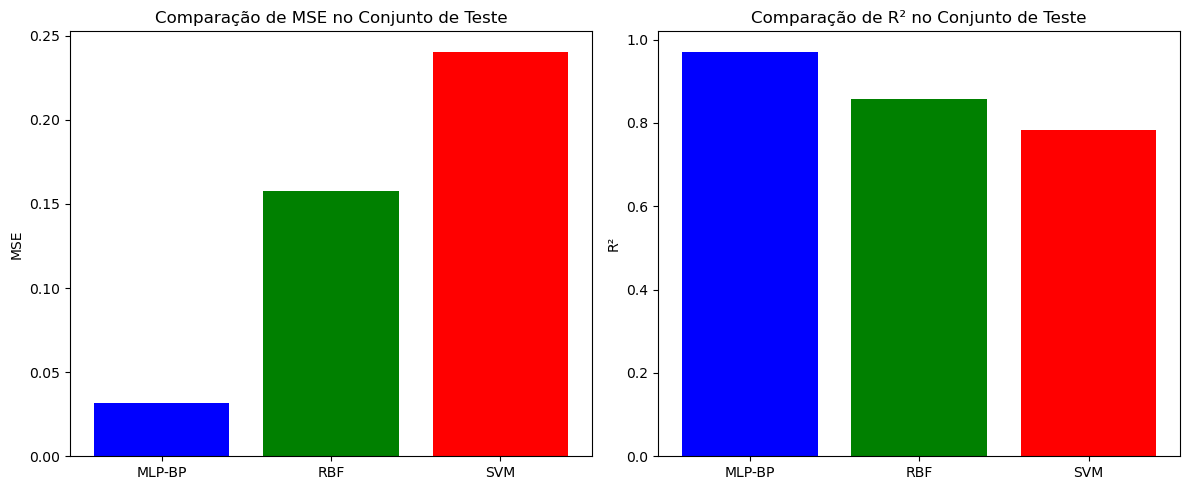

In [ ]:
print("\nComparação dos modelos:")
print("\nMLP-BP:")
print(f"MSE Teste: {mlp_metrics['mse']['test']:.4f} | R² Teste: {mlp_metrics['r2']['test']:.4f}")

print("\nRBF:")
print(f"MSE Teste: {rbf_metrics['mse']['test']:.4f} | R² Teste: {rbf_metrics['r2']['test']:.4f}")

print("\nSVM:")
print(f"MSE Teste: {svm_metrics['mse']['test']:.4f} | R² Teste: {svm_metrics['r2']['test']:.4f}")

# Plotar comparação
models = ['MLP-BP', 'RBF', 'SVM']
mse_test = [mlp_metrics['mse']['test'], rbf_metrics['mse']['test'], svm_metrics['mse']['test']]
r2_test = [mlp_metrics['r2']['test'], rbf_metrics['r2']['test'], svm_metrics['r2']['test']]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mse_test, color=['blue', 'green', 'red'])
plt.title('Comparação de MSE no Conjunto de Teste')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(models, r2_test, color=['blue', 'green', 'red'])
plt.title('Comparação de R² no Conjunto de Teste')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


### Gerando gráficos de comparação para MLP, RBF e SVM

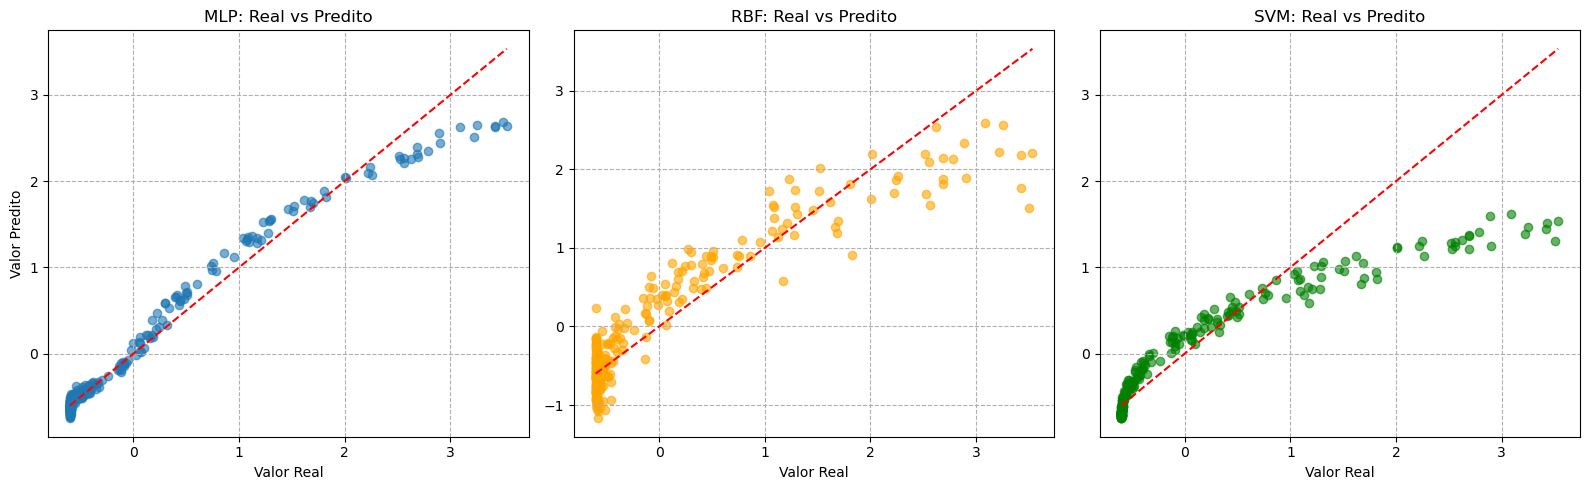

In [ ]:
fi,ax=plt.subplots(1,3,sharex=False,figsize=(16,5))

# Gráfico MLP
ax[0].scatter(y_test_scaled, y_mlp_pred_test, alpha=0.6, label='MLP')
ax[0].plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], 'r--')
ax[0].set_xlabel("Valor Real")
ax[0].set_ylabel("Valor Predito")
ax[0].set_title("MLP: Real vs Predito")
ax[0].grid(linestyle='dashed')

# Gráfico RBF
ax[1].scatter(y_test_scaled, y_rbf_pred_test, alpha=0.6, label='RBF', color='orange')
ax[1].plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], 'r--')
ax[1].set_xlabel("Valor Real")
ax[1].set_title("RBF: Real vs Predito")
ax[1].grid(linestyle='dashed')

# Gráfico SVM
ax[2].scatter(y_test_scaled, y_svm_pred_test, alpha=0.6, label='SVM', color='green')
ax[2].plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], 'r--')
ax[2].set_xlabel("Valor Real")
ax[2].set_title("SVM: Real vs Predito")
ax[2].grid(linestyle='dashed')

plt.tight_layout()
plt.show()

## Relatório

1. O MLP-BP apresentou o melhor desempenho geral, com menor MSE e maior R² no conjunto de teste. Isso era esperado, pois redes neurais multicamadas são aproximadores universais de funções. O principal destaque vai para a rápida convergência do modelo que com menos robustez que os outros modelos (converge com menos de 1000 iterações e possui apenas 20 neurônios na camada oculta), consegue ter um desempenho superior aos outros dois. Contudo, conseguiríamos ajustar os outros modelos para que desempenhassem de forma parecida (ponto 4. deste breve relatório), porém aumentando suas complexidades.

2. O RBF teve desempenho intermediário. Ele funciona bem para problemas com características radialmente simétricas, mas pode ter dificuldade com funções mais complexas.

3. O SVM com kernel RBF teve o "pior" desempenho neste problema. SVMs são poderosos para classificação binária, mas podem ser menos eficientes para problemas de regressão complexos
como este.

4. Há modos de aumentar as respectivas acurácias (aqui, vistas pelo score $R^2$). O problema passa a ser analisar se não há overfitting dos modelos ao aumentar seus desempenhos:
   - MLP-BP: Aumentar o número de neurônios na camada escondida
   - RBF: Aumentar o número de centros na região de decisão
   - SVM com Kernel RBF: Aumentar o parâmetro gamma que controla o alcance da influência dos pontos no problema

5. A função proposta parece ser melhor aproximada pela arquitetura do MLP-BP.